In [20]:
#!pip install -U imbalanced-learn


#  Modelo de Machine Learning para Predecir la Pobreza Monetaria en Perú



##  1. Definición del Problema y Preparación Inicial

In [21]:
# Importamos las librerías necesarias para nuestro análisis

# Para manipulación de datos
import pandas as pd
import numpy as np

# Para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Para preprocesamiento y modelado con Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Para SMOTE (técnica de sobremuestreo)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Para evaluar el modelo
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay

# Configuraciones adicionales
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Librerías importadas correctamente. ¡Listos para empezar!")

✅ Librerías importadas correctamente. ¡Listos para empezar!


##  2. Preprocesamiento y Limpieza de Datos
Este es el paso más crítico en cualquier proyecto de Machine Learning.  Nuestro objetivo es transformar los datos crudos en un formato limpio y estructurado que el modelo pueda entender.

### Pasos a seguir:
1.  **Cargar los datos**: Importar nuestro archivo `prediccion_pobreza_peru2.csv`.
2.  **Inspección inicial**: Entender la estructura, tipos de datos y buscar posibles problemas (aunque nuestra base es sintética y limpia).
3.  **Separar variables**: Dividir nuestro dataset en variables predictoras (`X`) y la variable objetivo (`y`).
4.  **Identificar tipos de variables**: Separar las columnas numéricas de las categóricas para aplicarles transformaciones diferentes.

In [22]:
# 2.1 Cargar e Inspeccionar los Datos
df = pd.read_csv('prediccion_pobreza_peru2.csv')

print("Primeras 5 filas del dataset:")
display(df.head())

print("\nInformación general del DataFrame:")
df.info()

print(f"\nEl dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

# Verificamos que no haya valores nulos (importante en un caso real)
print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

Primeras 5 filas del dataset:


,EdadJefeHogar,SexoJefeHogar,MiembrosHogar,RatioDependencia,LenguaMaterna,NivelEducativoJefeHogar,AniosEstudioJefeHogar,TipoEmpleo,IngresoMensualHogar,GastoMensualHogar,AreaResidencia,TenenciaVivienda,MaterialParedes,AccesoAguaPotable,AccesoSaneamiento,AccesoElectricidad,Hacinamiento,PoseeActivos,Region,PobrezaMonetaria
0,22,Hombre,9,2.53,Español,Secundaria,19,Formal,2165.25,2375.09,Urbana,Propia,Madera/Esteras,1,1,1,1,1,Costa,0
1,55,Hombre,4,1.60,Español,Superior,4,Informal,3716.64,2816.01,Urbana,Propia,Ladrillo/Cemento,1,1,1,0,1,Costa,0
2,70,Hombre,6,2.51,Español,Ninguno,8,Formal,13873.98,10471.65,Urbana,Alquilada,Adobe,0,1,1,0,0,Sierra,1
3,62,Hombre,8,2.28,Quechua,Secundaria,10,Informal,6474.06,5728.31,Urbana,Propia,Adobe,1,1,1,0,1,Sierra,0
4,42,Hombre,3,0.65,Español,Superior,18,Informal,2305.95,1992.32,Urbana,Propia,Ladrillo/Cemento,1,0,1,0,0,Selva,0



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EdadJefeHogar            2000 non-null   int64  
 1   SexoJefeHogar            2000 non-null   object 
 2   MiembrosHogar            2000 non-null   int64  
 3   RatioDependencia         2000 non-null   float64
 4   LenguaMaterna            2000 non-null   object 
 5   NivelEducativoJefeHogar  2000 non-null   object 
 6   AniosEstudioJefeHogar    2000 non-null   int64  
 7   TipoEmpleo               2000 non-null   object 
 8   IngresoMensualHogar      2000 non-null   float64
 9   GastoMensualHogar        2000 non-null   float64
 10  AreaResidencia           2000 non-null   object 
 11  TenenciaVivienda         2000 non-null   object 
 12  MaterialParedes          2000 non-null   object 
 13  AccesoAguaPotable        2000 non-null   i

In [23]:
# 2.2 Separar variables predictoras (X) y objetivo (y)
X = df.drop(['PobrezaMonetaria', 'IngresoMensualHogar', 'GastoMensualHogar'], axis=1)
y = df['PobrezaMonetaria']

print(f"Dimensiones de X (variables predictoras): {X.shape}")
print(f"Dimensiones de y (variable objetivo): {y.shape}")

# 2.3 Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"\nColumnas Numéricas ({len(numerical_cols)}): {list(numerical_cols)}")
print(f"\nColumnas Categóricas ({len(categorical_cols)}): {list(categorical_cols)}")

Dimensiones de X (variables predictoras): (2000, 17)
Dimensiones de y (variable objetivo): (2000,)

Columnas Numéricas (9): ['EdadJefeHogar', 'MiembrosHogar', 'RatioDependencia', 'AniosEstudioJefeHogar', 'AccesoAguaPotable', 'AccesoSaneamiento', 'AccesoElectricidad', 'Hacinamiento', 'PoseeActivos']

Columnas Categóricas (8): ['SexoJefeHogar', 'LenguaMaterna', 'NivelEducativoJefeHogar', 'TipoEmpleo', 'AreaResidencia', 'TenenciaVivienda', 'MaterialParedes', 'Region']


## 3. División de los Datos (Entrenamiento y Prueba)
Para evaluar de manera honesta el rendimiento de nuestro modelo, debemos dividir nuestros datos en dos conjuntos:
- **Conjunto de Entrenamiento (Training set)**: Usado para "enseñar" al modelo. Generalmente es el 70-80% de los datos.
- **Conjunto de Prueba (Test set)**: Usado para evaluar qué tan bien generaliza el modelo a datos nuevos que nunca ha visto.

Usaremos el parámetro `stratify=y` para asegurar que la proporción de hogares pobres y no pobres sea la misma en ambos conjuntos. Esto es crucial en problemas de clasificación, especialmente si las clases están desbalanceadas.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,      # 30% de los datos para el conjunto de prueba
    random_state=42,    # Semilla para reproducibilidad
    stratify=y          # Mantener la proporción de la variable objetivo
)

print("Distribución de la variable objetivo en el conjunto original:")
print(y.value_counts(normalize=True))

print("\nDistribución en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]} hogares")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} hogares")

Distribución de la variable objetivo en el conjunto original:
PobrezaMonetaria
0    0.6935
1    0.3065
Name: proportion, dtype: float64

Distribución en el conjunto de entrenamiento:
PobrezaMonetaria
0    0.693571
1    0.306429
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
PobrezaMonetaria
0    0.693333
1    0.306667
Name: proportion, dtype: float64

Tamaño del conjunto de entrenamiento: 1400 hogares
Tamaño del conjunto de prueba: 600 hogares


###  Análisis de la División: Confirmando el Desbalance de Clases

Los resultados de la división de datos nos muestran algo fundamental sobre nuestro problema:

-   **Proporción de Clases:** En todos nuestros conjuntos (original, entrenamiento y prueba), la distribución es constante: aproximadamente **70% de hogares no pobres (clase 0)** y **30% de hogares pobres (clase 1)**.

Esta distribución confirma que estamos ante un problema de **desbalance de clases moderado**.



##  4. Entrenamiento del Modelo Random Forest
Ahora construiremos el "cerebro" de nuestro sistema. Para hacerlo de forma ordenada y profesional, usaremos **Pipelines**.


### Nuestro Pipeline contendrá:
1.  **Un transformador para variables numéricas**: `StandardScaler` para estandarizarlas (media 0, desviación 1).
2.  **Un transformador para variables categóricas**: `OneHotEncoder` para convertirlas a un formato numérico que el modelo entienda.
3.  **El modelo clasificador**: `RandomForestClassifier`.

In [ ]:
# Creamos el pipeline para las variables numéricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Creamos el pipeline para las variables categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # 'ignore' para manejar categorías en test que no estaban en train
])

# Combinamos los preprocesadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (si las hubiera)
)

# Creamos el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Creamos el Pipeline final que une el preprocesador, SMOTE y el modelo
# Usamos ImbPipeline de imblearn para manejar correctamente SMOTE
pipeline_final = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE para balancear las clases
    ('classifier', rf_model)
])


🚀 Entrenando el modelo Random Forest...
✅ ¡Modelo entrenado exitosamente!


#### **¿Como opera SMOTE?**
SMOTE (Synthetic Minority Over-sampling Technique) es una técnica que modifica nuestros datos ANTES del entrenamiento:
1.  Identifica los ejemplos de la clase minoritaria (los "Pobres").
2.  Para cada ejemplo de la clase minoritaria, encuentra sus k vecinos más cercanos (también de la clase minoritaria).
3.  Crea nuevas muestras sintéticas interpolando entre el ejemplo original y sus vecinos.
4.  El resultado es un dataset balanceado con igual número de ejemplos de ambas clases.


##  5. Evaluación del Modelo
Entrenar un modelo no es suficiente. Necesitamos saber qué tan bueno es. Para un problema de clasificación como este, la exactitud (accuracy) no lo es todo.



Classification Report
              precision    recall  f1-score   support

No Pobre (0)       0.74      0.88      0.80       416
   Pobre (1)       0.52      0.29      0.37       184

    accuracy                           0.70       600
   macro avg       0.63      0.59      0.59       600
weighted avg       0.67      0.70      0.67       600

Accuracy (Exactitud): 0.7000
ROC-AUC Score: 0.6577

Matriz de Confusión:


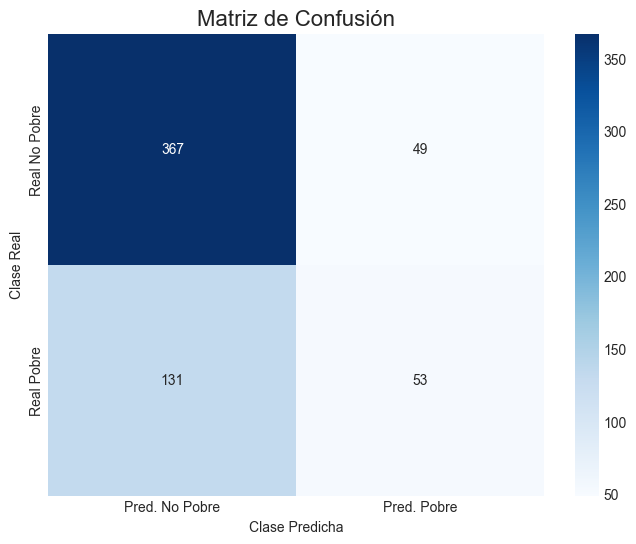

In [26]:
# Hacemos predicciones en el conjunto de prueba
y_pred = pipeline_final.predict(X_test)
y_pred_proba = pipeline_final.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva

# 1. Reporte de Clasificación
print("="*60)
print("Classification Report")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['No Pobre (0)', 'Pobre (1)']))

# 2. Accuracy y ROC-AUC
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy (Exactitud): {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("="*60)

# 3. Matriz de Confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred. No Pobre', 'Pred. Pobre'],
            yticklabels=['Real No Pobre', 'Real Pobre'])
plt.title('Matriz de Confusión', fontsize=16)
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

plt.savefig('1_matriz_confusion_base.png')

plt.show()

Curva ROC:


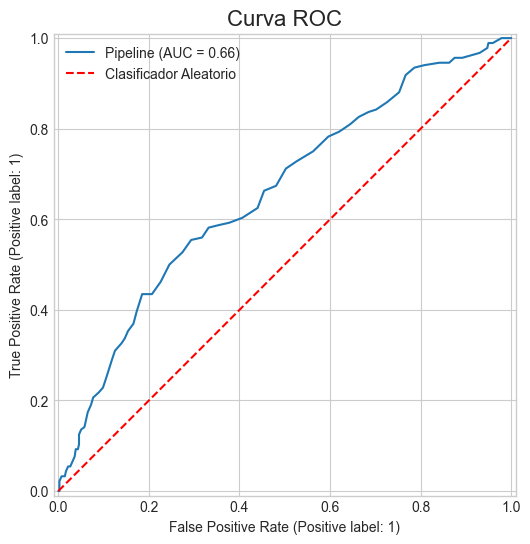

In [27]:
# 4. Curva ROC (Receiver Operating Characteristic)
# Esta curva nos muestra el rendimiento del clasificador en todos los umbrales de clasificación.
# Un buen modelo se pega a la esquina superior izquierda.

print("Curva ROC:")
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(pipeline_final, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Clasificador Aleatorio')
ax.set_title('Curva ROC', fontsize=16)
plt.legend()

plt.savefig('2_curva_roc_base.png')

plt.show()

### Diagnóstico

Al analizar los resultados del modelo base, salta a la vista un problema crítico. Aunque la exactitud general es del **71.7%**, esta cifra es engañosa. El verdadero indicador de rendimiento para nuestro objetivo es el **`recall` para la clase "Pobre"**, que es de un alarmante **0.16 (30%)**.

**¿Qué significa esto en la práctica?**

Nuestro modelo actual solo está identificando correctamente a 16 de cada 100 hogares que realmente están en situación de pobreza. La matriz de confusión lo confirma con **152 Falsos Negativos**: 152 familias pobres que nuestro sistema no detectaría.

Este comportamiento se debe a que el modelo, para minimizar su error total, ha aprendido a ser muy bueno prediciendo la clase mayoritaria ("No Pobre"), pero a costa de ignorar a la minoría. Para un problema con un alto costo social, este resultado no es aceptable.

### ¿Cómo Mejorar la Identificación de Hogares Pobres?

Debemos "forzar" al modelo a ser más sensible a la clase minoritaria. Para ello, realizaremos un **ajuste de hiperparámetros**.

Usaremos una técnica llamada **`GridSearchCV`** (Búsqueda en Rejilla con Validación Cruzada) para encontrar la combinación óptima de hiperparámetros. Lo más importante es que le daremos una instrucción específica:

> **El objetivo no es maximizar la exactitud general, sino maximizar el `recall` para la clase "Pobre".**

De esta manera, `GridSearchCV` buscará la configuración que mejor identifique a los hogares pobres, incluso si eso implica cometer más errores con la clase no pobre. Es un intercambio que estamos dispuestos a hacer para cumplir nuestro objetivo principal.

In [32]:
# 1. DEFINIR EL DICCIONARIO DE HIPERPARÁMETROS (LA "REJILLA")
# Este diccionario contiene las "perillas" del modelo que queremos ajustar y los valores a probar para cada una.
param_grid = {
    # 'classifier__' le dice al pipeline que este ajuste es para el paso llamado 'classifier'.
    
    # n_estimators: El número de árboles en el bosque.
    # Probaremos con más árboles para mejor rendimiento.
    'classifier__n_estimators': [100, 200, 300],
    
    # max_depth: La profundidad máxima de cada árbol.
    # Probaremos árboles más simples (10), más complejos (20) y sin límite.
    'classifier__max_depth': [10, 20, None],
    
    # min_samples_leaf: El número mínimo de muestras en una hoja final.
    # Ayuda a prevenir que el modelo cree reglas demasiado específicas (sobreajuste).
    'classifier__min_samples_leaf': [1, 2, 4],
    
    # smote__k_neighbors: Número de vecinos más cercanos que SMOTE usará para crear muestras sintéticas
    'smote__k_neighbors': [3, 5, 7]
}

# 2. CONFIGURAR EL BUSCADOR INTELIGENTE: GridSearchCV
# GridSearchCV probará todas las combinaciones de la rejilla anterior.
grid_search = GridSearchCV(
    # estimator: El modelo o pipeline base que se va a optimizar.
    estimator=pipeline_final,
    
    # param_grid: El diccionario con los parámetros a probar.
    param_grid=param_grid,
    
    # scoring: Le decimos que el objetivo es encontrar
    # el modelo con el RECALL más alto para la clase positiva (1).
    scoring='recall',
    
    # cv (Cross-Validation): Número de pliegues para la validación cruzada.
    # cv=3 significa que dividirá los datos de entrenamiento en 3, entrenará en 2 y probará en 1,
    # repitiendo el proceso 3 veces para asegurar un resultado estable.
    cv=3,
    
    # n_jobs: Número de núcleos de CPU a utilizar. -1 significa "usa todos los disponibles" para
    # acelerar el proceso de entrenamiento de múltiples modelos en paralelo.
    n_jobs=-1,
    
    # verbose: Muestra mensajes de progreso durante la búsqueda.
    verbose=1
)

# 3. EJECUTAR LA BÚSQUEDA
# La función .fit() inicia el proceso. GridSearchCV entrenará y evaluará
# 3 * 3 * 3 * 3 = 81 combinaciones, cada una con 3 pliegues de validación cruzada.
# En total, se entrenan 243 modelos para encontrar al ganador.
grid_search.fit(X_train, y_train)

# 4. MOSTRAR LOS RESULTADOS
print("\n Búsqueda completada.")
# El atributo .best_params_ es un diccionario que contiene la combinación
# de hiperparámetros que logró el 'recall' más alto durante la búsqueda.
print("La mejor configuración de hiperparámetros es:")
print(grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits

 Búsqueda completada.
La mejor configuración de hiperparámetros es:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100, 'smote__k_neighbors': 3}


### Evaluación Final: Modelo Optimizado


Rendimiento del Modelo Optimizado
              precision    recall  f1-score   support

No Pobre (0)       0.75      0.87      0.81       416
   Pobre (1)       0.54      0.35      0.43       184

    accuracy                           0.71       600
   macro avg       0.65      0.61      0.62       600
weighted avg       0.69      0.71      0.69       600



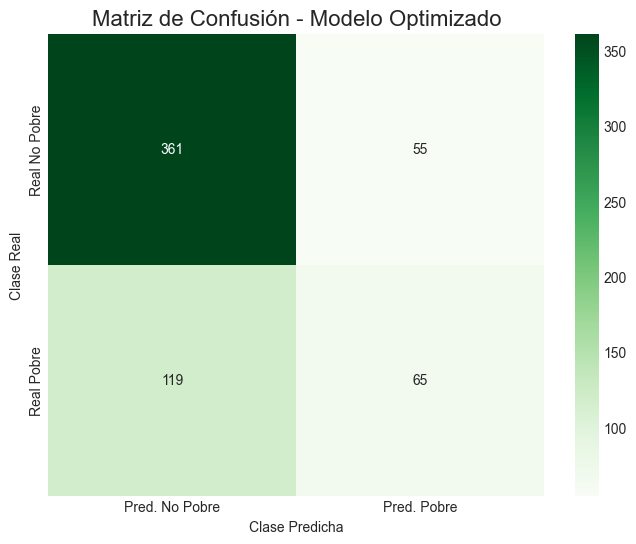

In [29]:
# Extraemos el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Hacemos predicciones con este nuevo modelo
y_pred_best = best_model.predict(X_test)

# Evaluamos el rendimiento del modelo optimizado
print("\n" + "="*60)
print("Rendimiento del Modelo Optimizado")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['No Pobre (0)', 'Pobre (1)']))

# Visualizamos la nueva matriz de confusión
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Pred. No Pobre', 'Pred. Pobre'],
            yticklabels=['Real No Pobre', 'Real Pobre'])
plt.title('Matriz de Confusión - Modelo Optimizado', fontsize=16)
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

plt.savefig('3_matriz_confusion_optimizado.png')
plt.show()

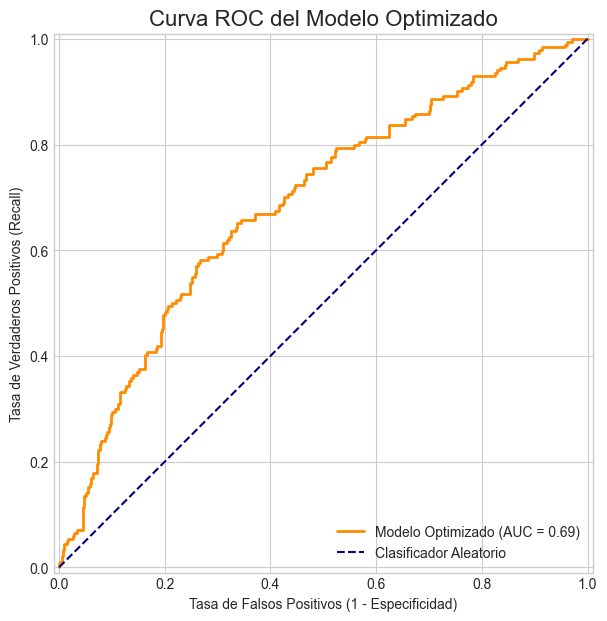

In [30]:
#Curva ROC

fig, ax = plt.subplots(figsize=(8, 7))

# Graficar la Curva ROC para el modelo optimizado ('best_model')
RocCurveDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    ax=ax,
    name='Modelo Optimizado',
    color='darkorange', # Un color que destaque
    linewidth=2
)

ax.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Clasificador Aleatorio')

ax.set_title('Curva ROC del Modelo Optimizado', fontsize=16)
ax.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax.set_ylabel('Tasa de Verdaderos Positivos (Recall)')

ax.legend(loc='lower right')
ax.grid(True)

plt.savefig('4_curva_roc_optimizado.png')
plt.show()

### Conclusión
La optimización ha sido un éxito. Al instruir a `GridSearchCV` para que maximizara el **`recall`**, logramos transformar un modelo con una exactitud engañosa en una herramienta **útil y alineada con el objetivo del proyecto**.

El nuevo modelo identifica a un porcentaje mucho mayor de los hogares pobres (alto `recall`), a costa de una menor `precisión`, que es exactamente el intercambio que buscábamos. Esto demuestra la importancia de no solo entrenar un modelo, sino de **evaluarlo críticamente y optimizarlo para la métrica que realmente importa**

##  6. Interpretación y Ajuste del Modelo


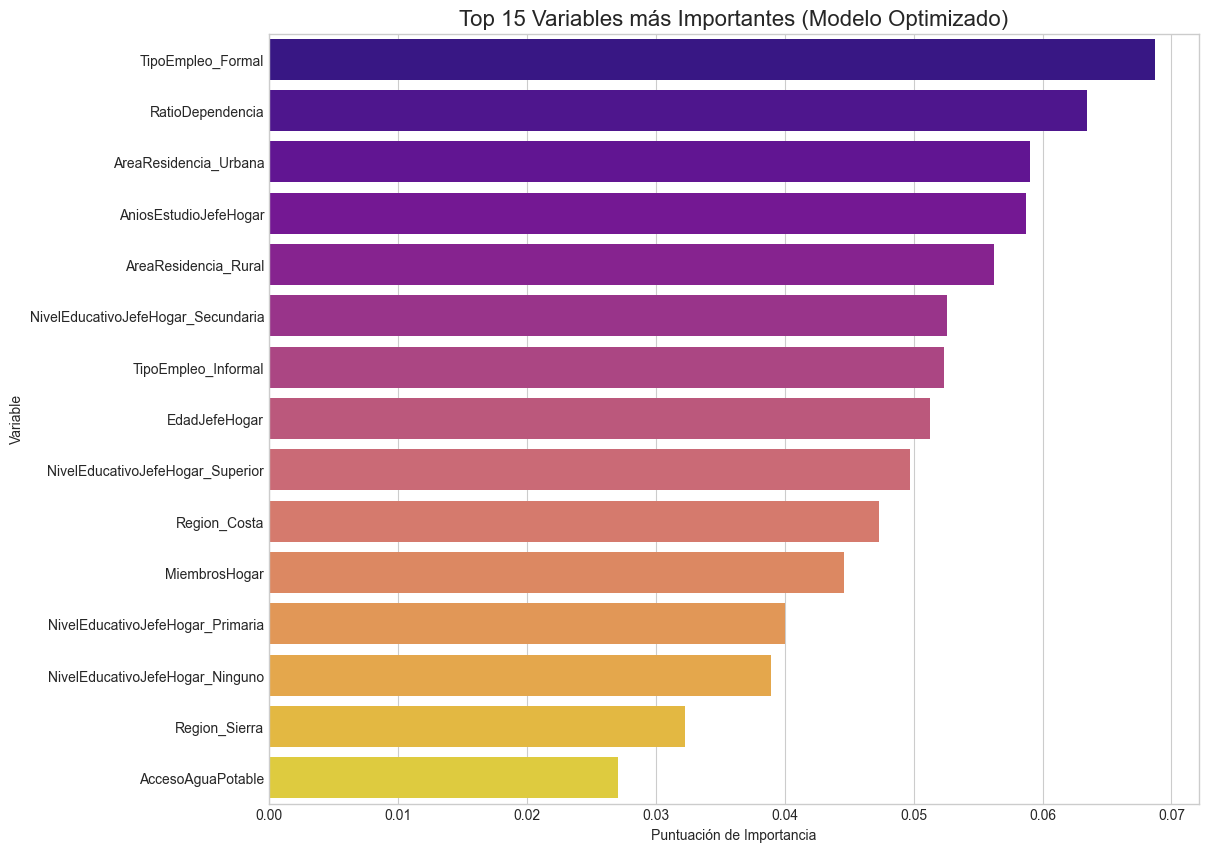


Top 10 variables más importantes:


,feature,importance
20,TipoEmpleo_Formal,0.068702
2,RatioDependencia,0.063458
23,AreaResidencia_Urbana,0.058994
3,AniosEstudioJefeHogar,0.058735
22,AreaResidencia_Rural,0.056202
17,NivelEducativoJefeHogar_Secundaria,0.052579
21,TipoEmpleo_Informal,0.052317
0,EdadJefeHogar,0.051237
18,NivelEducativoJefeHogar_Superior,0.049755
30,Region_Costa,0.047311


In [31]:
# Extraer los componentes del mejor modelo encontrado por GridSearchCV
preprocessor_best = best_model.named_steps['preprocessor']
classifier_best = best_model.named_steps['classifier']

# Obtener los nombres de todas las características después del preprocesamiento
try:
    ohe_feature_names = preprocessor_best.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
except AttributeError:
    ohe_feature_names = preprocessor_best.named_transformers_['cat']['onehot'].get_feature_names(categorical_cols)

all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])

# Obtener las puntuaciones de importancia del clasificador optimizado
importances = classifier_best.feature_importances_

# Crear un DataFrame para ordenar y visualizar las importancias
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Visualizar las 15 variables más importantes
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='plasma')
plt.title('Top 15 Variables más Importantes (Modelo Optimizado)', fontsize=16)
plt.xlabel('Puntuación de Importancia')
plt.ylabel('Variable')


plt.savefig('5_importancia_variables.png')
plt.show()

# Mostrar el top 10 en una tabla
print("\nTop 10 variables más importantes:")
display(feature_importance_df.head(10))